# Bi-directional seq2seq using GloVe embeddings, not working yet. 

In [1]:
from attention import AttentionLayer
import numpy as np  
import pandas as pd 
import re           
from bs4 import BeautifulSoup 
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords   
import warnings
import matplotlib.pyplot as plt
%matplotlib
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

Using TensorFlow backend.


Using matplotlib backend: TkAgg


In [2]:
data=pd.read_csv("..\\Data\\model_training\\100000_samples_Reviews.csv")
data.drop_duplicates(subset=['Text'],inplace=True)  #dropping duplicates
data.dropna(axis=0,inplace=True)#dropping na rows

In [3]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

                           "you're": "you are", "you've": "you have"}

In [4]:
# data=data.rename(columns = {'article': 'Text', 'title': 'Summary'})
data.head()

,Text,Summary
0,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labr...,Good Quality Dog Food
1,"Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as ""Jumbo"".",Not as Advertised
2,"This is a confection that has been around a few centuries. It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with ...","""Delight"" says it all"
3,If you are looking for the secret ingredient in Robitussin I believe I have found it. I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda. The fl...,Cough Medicine
4,"Great taffy at a great price. There was a wide assortment of yummy taffy. Delivery was very quick. If your a taffy lover, this is a deal.",Great taffy


In [5]:
stop_words = set(stopwords.words('english')) 
def text_cleaner(text):
    newString = text.lower()
    newString = BeautifulSoup(newString, exclude_encodings="lxml").text # removes html/xml taggs
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    tokens = [w for w in newString.split() if not w in stop_words]
    long_words=[]
    for i in tokens:
        if len(i)>=3:                  #removing short word
            long_words.append(i)   
    return (" ".join(long_words)).strip()

cleaned_text = []
for t in data['Text']:
    cleaned_text.append(text_cleaner(t))

In [6]:
def summary_cleaner(text):
    newString = re.sub('"','', text)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString)
    newString = newString.lower()
    tokens=newString.split()
    newString=''
    for i in tokens:
        if len(i)>1:                                 
            newString=newString+i+' '  
    return newString

#Call the above function
cleaned_summary = []
for t in data['Summary']:
    cleaned_summary.append(summary_cleaner(t))

data['cleaned_text']=cleaned_text
data['cleaned_summary']=cleaned_summary
data['cleaned_summary'].replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)

In [7]:
for i in range(2):
    print("Review:",data['cleaned_text'][i])
    print("Summary:",data['cleaned_summary'][i])
    print()

Review: bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better
Summary: good quality dog food 

Review: product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo
Summary: not as advertised 



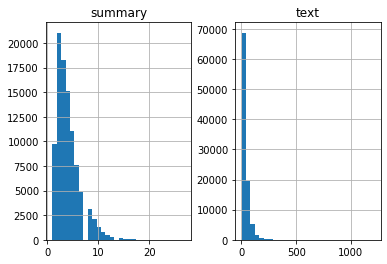

In [8]:
text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in data['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in data['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})
length_df.hist(bins = 30)
plt.show()

In [9]:
max_len_text=30
max_len_summary=8

In [10]:
cleaned_text =np.array(data['cleaned_text'])
cleaned_summary=np.array(data['cleaned_summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_len_summary and len(cleaned_text[i].split())<=max_len_text):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        
df=pd.DataFrame({'text':short_text,'summary':short_summary})

In [11]:
# Apply start of sentence/ end of sentence tokens to summary, used for 
df['summary'] = df['summary'].apply(lambda x : 'sostok '+ x + ' eostok')
df

,text,summary
0,bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better,sostok good quality dog food eostok
1,product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo,sostok not as advertised eostok
2,looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal,sostok cough medicine eostok
3,great taffy great price wide assortment yummy taffy delivery quick taffy lover deal,sostok great taffy eostok
4,saltwater taffy great flavors soft chewy candy individually wrapped well none candies stuck together happen expensive version fralinger would highly recommend candy served beach themed party every...,sostok great just as good as the expensive brands eostok
...,...,...
52254,favorite coffee also best price found thanks amazon com,sostok great tasting coffee eostok
52255,generally like millstone coffees one major disappointment weak flavor taste drinker weak non acidic coffee might find liking,sostok millstone kona bad blend eostok
52256,disappointed trying use mixing fresh roast beans grinding seem like old stock beans practically dessicated fresh roasted sheen bean speak lot like typical pack hotel coffee would recommend reorder,sostok not very fresh beans are very dry eostok
52257,enjoy blend fan starbuck coffee enjoy looking lighter roast good price flavor simply worst kona blend ever tried maybe taste different moving different blend,sostok really did not like this one eostok


In [12]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(np.array(df['text']),np.array(df['summary']),test_size=0.1,random_state=0,shuffle=True)

In [13]:
y_val[0:10]

array(['sostok great coffee  eostok',
       'sostok iby far the best gluten free pasta  eostok',
       'sostok misleading  eostok', 'sostok quality tea  eostok',
       'sostok good coffee  eostok',
       'sostok my favorite cup tea blend  eostok',
       'sostok good food  eostok', 'sostok great pancakes  eostok',
       'sostok light and tasty  eostok', 'sostok powder cereal  eostok'],
      dtype=object)

## X: Text tokenizer

In [14]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_tr))

thresh=4 # threshold = 4. Word whose count is below 4 is considered as a rare word
cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 66.13882696594665
Total Coverage of rare words: 2.7712041060446184


In [15]:
tot_cnt-cnt

8810

In [16]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) # for the vocabulary
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_len_text, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_len_text, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1
x_voc

8811

In [17]:
x_tr

array([[ 504,  112,   86, ...,    0,    0,    0],
       [  74,  153, 2113, ...,  140,   72,   87],
       [ 150,    2,   68, ...,    0,    0,    0],
       ...,
       [ 454,  573,  122, ...,    0,    0,    0],
       [   6,  346,  953, ...,    0,    0,    0],
       [  12,   50,  586, ...,    0,    0,    0]])

## Y: Summary Tokenizer

In [18]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

thresh=6 # threshold = 6. Word whose count is below 6 is considered as a rare word, since summaries are less.
cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 77.7399029025927
Total Coverage of rare words: 5.128902602411595


In [19]:
tot_cnt-cnt

2155

In [20]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_len_summary, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_len_summary, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1
y_voc

2156

In [21]:
y_tokenizer.word_counts['sostok']-len(y_tr) # should be 0, check if there are any sostok's in the word list. 

0

In [22]:
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

In [23]:
ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

## GloVe embeddings

In [24]:
from load_glove_embeddings import load_glove_embeddings # local function from .py file
glove_dimension = 50
import time
timer_start = time.time()
# word2index, embedding_matrix = load_glove_embeddings('Data/word_embeddings/glove.6B.'+str(glove_dimension)+'d.txt', embedding_dim=glove_dimension, include_empty_char=False)
word2index, embedding_matrix = load_glove_embeddings('../Data/word_embeddings/glove.6B.'+str(glove_dimension)+'d.txt', embedding_dim=glove_dimension, include_empty_char=False)

print('Found %s word vectors.' % len(word2index))
print("Creating embeddings_index took", round(time.time() - timer_start, 1), "seconds.")
del timer_start

Found 400000 word vectors.
Creating embeddings_index took 12.6 seconds.


In [25]:
embedding_matrix

array([[ 0.41800001,  0.24968   , -0.41242   , ..., -0.18411   ,
        -0.11514   , -0.78580999],
       [ 0.013441  ,  0.23682   , -0.16899   , ..., -0.56656998,
         0.044691  ,  0.30392   ],
       [ 0.15164   ,  0.30177   , -0.16763   , ..., -0.35652   ,
         0.016413  ,  0.10216   ],
       ...,
       [-0.51181   ,  0.058706  ,  1.09130001, ..., -0.25003001,
        -1.125     ,  1.58630002],
       [-0.75897998, -0.47426   ,  0.47369999, ...,  0.78953999,
        -0.014116  ,  0.64480001],
       [ 0.072617  , -0.51393002,  0.47279999, ..., -0.18907   ,
        -0.59021002,  0.55558997]])

In [26]:
from itertools import islice
list(islice(word2index.items(), 10))

[('the', 0),
 (',', 1),
 ('.', 2),
 ('of', 3),
 ('to', 4),
 ('and', 5),
 ('in', 6),
 ('a', 7),
 ('"', 8),
 ("'s", 9)]

In [27]:
def embedding_matrix_creater(embedding_dimention, word_index): 
    """
    Uses GloVe as a global word embedding. 
    
    embedding_dimention: usually in the title of glove.6D.'embedding_dimention', in this notebook use 50. 
    word_index: the input word embeddings
    
    returns: a local embedding matrix, to be input as weights [embedding] for the constructor
        for keras' Embedding object. 
    """
    local_embedding_matrix = np.zeros((len(word_index) + 1, embedding_dimention))
    for word, i in word_index.items():
        embedding_vector = word2index.get(word) # from cell above, from glove.
        if embedding_vector is not None:
          # words not found in embedding index will be all-zeros.
            local_embedding_matrix[i] = embedding_vector
    return local_embedding_matrix

In [28]:
len(x_tokenizer.word_index)

26018

In [29]:
dict(islice(x_tokenizer.word_index.items(), 5))

{'great': 1, 'good': 2, 'like': 3, 'love': 4, 'taste': 5}

In [30]:
print('x_tokenizer.num_words:', x_tokenizer.num_words)
print('x_voc:', x_voc)

x_tokenizer.num_words: 8810
x_voc: 8811


In [31]:
from tensorflow.keras.layers import Embedding
text_embedding_matrix = embedding_matrix_creater(glove_dimension, 
        word_index=dict(islice(x_tokenizer.word_index.items(), x_tokenizer.num_words+1)))
print(text_embedding_matrix.shape)

sum_embedding_matrix = embedding_matrix_creater(glove_dimension, 
        word_index=dict(islice(y_tokenizer.word_index.items(), y_tokenizer.num_words+1)))
print(sum_embedding_matrix.shape)

encoder_embedding_layer = Embedding(input_dim = int(text_embedding_matrix.shape[0]), # vocab size
                                    output_dim = int(text_embedding_matrix.shape[1]), # embedding dimension
                                    input_length = max_len_text, # sequence length
                                    weights = [text_embedding_matrix],
                                    trainable = False) # False because these embeddings have already been trained. 

decoder_embedding_layer = Embedding(input_dim = int(sum_embedding_matrix.shape[0]),
                                    output_dim = int(sum_embedding_matrix.shape[1]),
                                    input_length = max_len_summary,
                                    weights = [sum_embedding_matrix],
                                    trainable = False) # False because these embeddings have already been trained. 

(8812, 50)
(2157, 50)


In [32]:
sum_embedding_matrix

array([[    0.,     0.,     0., ...,     0.,     0.,     0.],
       [    0.,     0.,     0., ...,     0.,     0.,     0.],
       [    0.,     0.,     0., ...,     0.,     0.,     0.],
       ...,
       [14387., 14387., 14387., ..., 14387., 14387., 14387.],
       [51257., 51257., 51257., ..., 51257., 51257., 51257.],
       [ 4037.,  4037.,  4037., ...,  4037.,  4037.,  4037.]])

In [33]:
text_embedding_matrix

array([[0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [3.5300e+02, 3.5300e+02, 3.5300e+02, ..., 3.5300e+02, 3.5300e+02,
        3.5300e+02],
       [2.1900e+02, 2.1900e+02, 2.1900e+02, ..., 2.1900e+02, 2.1900e+02,
        2.1900e+02],
       ...,
       [1.8357e+04, 1.8357e+04, 1.8357e+04, ..., 1.8357e+04, 1.8357e+04,
        1.8357e+04],
       [2.4804e+05, 2.4804e+05, 2.4804e+05, ..., 2.4804e+05, 2.4804e+05,
        2.4804e+05],
       [1.0792e+04, 1.0792e+04, 1.0792e+04, ..., 1.0792e+04, 1.0792e+04,
        1.0792e+04]])

In [34]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dropout,  Dense, Activation,Add, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

In [46]:
# # model
# """
# Bidirectional LSTM: Others Inspired Encoder-Decoder-seq2seq
# """
# HIDDEN_UNITS = 200
# encoder_inputs = Input(shape=(max_len_text,))
# encoder_embedding = encoder_embedding_layer(encoder_inputs)
# encoder_LSTM = LSTM(HIDDEN_UNITS, return_state=True)
# encoder_LSTM_R = LSTM(HIDDEN_UNITS, return_state=True, go_backwards=True)
# encoder_outputs_R, state_h_R, state_c_R = encoder_LSTM_R(encoder_embedding)
# encoder_outputs, state_h, state_c = encoder_LSTM(encoder_embedding)

# final_h = Add()([state_h, state_h_R])
# final_c = Add()([state_c, state_c_R])
# encoder_states = [final_h, final_c]

# """
# decoder
# """
# decoder_inputs = Input(shape=(max_len_summary,))
# decoder_embedding = decoder_embedding_layer(decoder_inputs)
# decoder_LSTM = LSTM(HIDDEN_UNITS, return_sequences=True, return_state=True)
# decoder_outputs, _, _ = decoder_LSTM(decoder_embedding, initial_state=encoder_states) 
# decoder_dense = Dense(sum_embedding_matrix.shape[0], activation='linear')
# decoder_outputs = decoder_dense(decoder_outputs)

# model= Model(inputs=[encoder_inputs,decoder_inputs], outputs=decoder_outputs)
# model.summary()

In [47]:
# model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)
# history=model.fit([x_tr,y_tr[:,:]], 
#                   y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,:],
#                   epochs=2,
#                   callbacks=[es],
#                   batch_size=128,
#                   validation_data=([x_val,y_val[:,:]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,:]))

In [48]:
# plt.figure(figsize=(10, 6))
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

## Inferernce, decoder

In [49]:
reverse_target_word_index=y_tokenizer.index_word 
reverse_source_word_index=x_tokenizer.index_word 
target_word_index=y_tokenizer.word_index

In [50]:
# # model
# """
# Bidirectional LSTM: Others Inspired Encoder-Decoder-seq2seq
# """
# HIDDEN_UNITS = 200
# encoder_inputs = Input(shape=(max_len_text,))
# encoder_embedding = encoder_embedding_layer(encoder_inputs)
# encoder_LSTM = LSTM(HIDDEN_UNITS, return_state=True)
# encoder_LSTM_R = LSTM(HIDDEN_UNITS, return_state=True, go_backwards=True)
# encoder_outputs_R, state_h_R, state_c_R = encoder_LSTM_R(encoder_embedding)
# encoder_outputs, state_h, state_c = encoder_LSTM(encoder_embedding)

# final_h = Add()([state_h, state_h_R])
# final_c = Add()([state_c, state_c_R])
# encoder_states = [final_h, final_c]

# """
# decoder
# """
# decoder_inputs = Input(shape=(max_len_summary,))
# decoder_embedding = decoder_embedding_layer(decoder_inputs)
# decoder_LSTM = LSTM(HIDDEN_UNITS, return_sequences=True, return_state=True)
# decoder_outputs, _, _ = decoder_LSTM(decoder_embedding, initial_state=encoder_states) 
# decoder_dense = Dense(sum_embedding_matrix.shape[0], activation='linear')
# decoder_outputs = decoder_dense(decoder_outputs)

# model= Model(inputs=[encoder_inputs,decoder_inputs], outputs=decoder_outputs)
# model.summary()

# # plot the model
# import os
# os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
# import tensorflow as tf
# tf.keras.utils.plot_model(model, to_file='model_bi.png', show_shapes=True)

In [51]:
# # Custom Model
# encoder_inference_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# decoder_state_input_h = Input(shape=(HIDDEN_UNITS,))  # These states are required for feeding back to our next timestep decoder
# decoder_state_input_c = Input(shape=(HIDDEN_UNITS,))
# decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# #Now we shall reuse our decoder
# summary_for_decoder = Input(shape=(1,))
# embedding_summary_decoder = embedding_decoder_layer(summary_for_decoder)

# decoder_inference_output, decoder_states_c, decoder_states_h = decoder_lstm_layer(embedding_summary_decoder, initial_state = decoder_states_inputs)
# decoder_states_outputs = [decoder_states_c, decoder_states_h]
# output_prob = decoder_dense_layer(decoder_inference_output)
# decoder_inference_model = Model(
#     [summary_for_decoder] + decoder_states_inputs,
#     decoder_states_outputs + [output_prob])

In [52]:
# # Encode the input sequence to get the feature vector
# encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# # Decoder setup
# # Below tensors will hold the states of the previous time step
# decoder_state_input_h = Input(shape=(HIDDEN_UNITS,)) #
# decoder_state_input_c = Input(shape=(HIDDEN_UNITS,)) #
# decoder_hidden_state_input = Input(shape=(max_len_text,HIDDEN_UNITS))

# # Get the embeddings of the decoder sequence
# dec_emb2= decoder_embedding_layer(decoder_inputs) 
# # To predict the next word in the sequence, set the initial states to the states from the previous time step
# decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# #attention inference
# attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
# decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# # A dense softmax layer to generate prob dist. over the target vocabulary
# decoder_outputs2 = decoder_dense(decoder_inf_concat) 

# # Final decoder model
# decoder_model = Model(
#     [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
#     [decoder_outputs2] + [state_h2, state_c2])

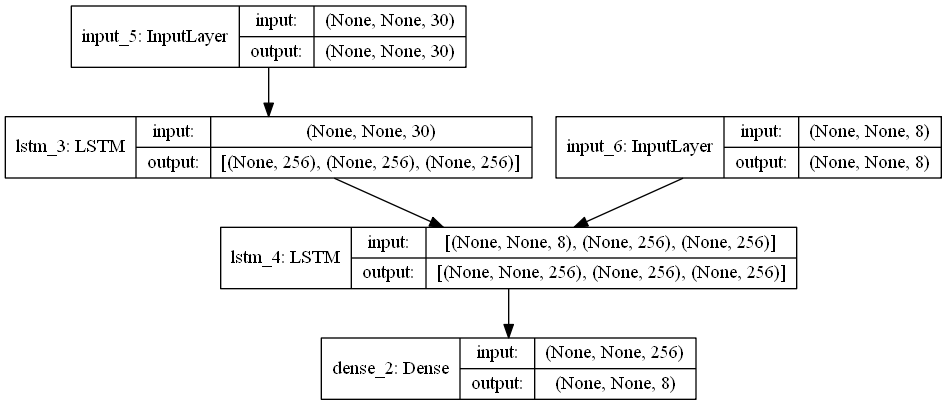

In [53]:
from keras.models import Model
from keras.layers import Input
from keras.layers import LSTM
from keras.layers import Dense
from keras.utils.vis_utils import plot_model

# configure
num_encoder_tokens = 30
num_decoder_tokens = 8
latent_dim = 256

# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))

# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# plot the model
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_bi.png', show_shapes=True)

In [54]:
# model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)
# history=model.fit([x_tr,y_tr[:,:]], 
#                   y_tr.reshape(1,y_tr.shape[0],y_tr.shape[1], 1)[:,:],
#                   epochs=2,
#                   callbacks=[es],
#                   batch_size=128,
#                   validation_data=([x_val,y_val[:,:]], y_val.reshape(1,y_val.shape[0],y_val.shape[1], 1)[:,:]))

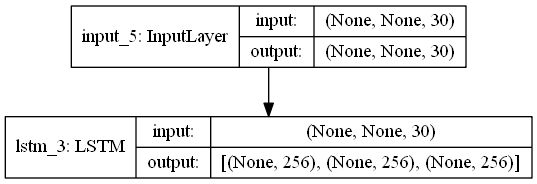

In [55]:
# define encoder inference model
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])
plot_model(encoder_model, to_file='encoder_model_bi.png', show_shapes=True)

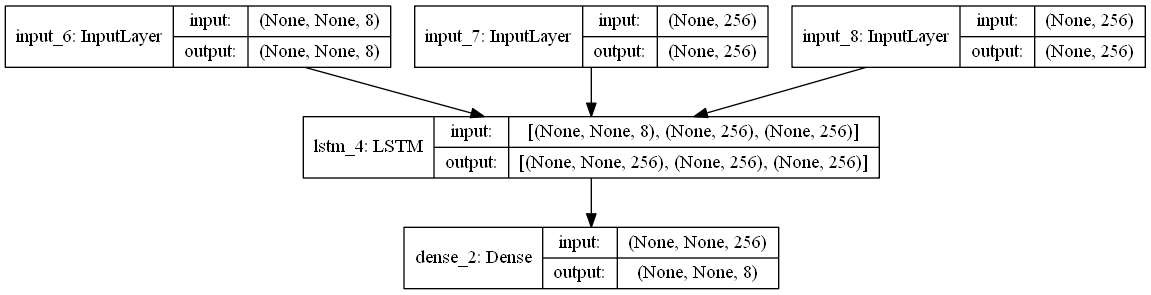

In [56]:
# define decoder inference model
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_len_text,latent_dim)) # NEW

decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, 
                                initial_state=[decoder_state_input_h, decoder_state_input_c])
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h,decoder_state_input_c], 
    [decoder_outputs] + [state_h, state_c])
plot_model(decoder_model, to_file='decoder_model_bi.png', show_shapes=True)

In [57]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [58]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    print(input_seq)
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    print('e_out:', e_out[0][0])
    print('e_h:', e_h[0][0])
    print('e_c:', e_c[0][0])
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Chose the 'start' word as the first word of the target sequence
    target_seq[0, 0] = target_word_index['sostok']
    print(target_word_index['sostok'])
    print('target_seq.shape:', target_seq.shape)
    print('target_seq.shape:', target_seq)
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
#         print("output_tokens:", output_tokens)
    
        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
#         print(sampled_token_index)
        sampled_token = reverse_target_word_index[sampled_token_index]
        print('sample token:', sampled_token)
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok' or len(decoded_sentence.split()) >= (max_len_summary-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index
        
        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [59]:
for i in range(0,20):
    print("Review:",seq2text(x_tr[i]))
    print("Original summary:",seq2summary(y_tr[i]))
    print()
    print("Predicted summary:",decode_sequence(x_tr[i].reshape(1,1,max_len_text)))
    print("________________________________________________________")
    print("\n")

Review: oatmeal old hard parts bad taste throw away never order 
Original summary: bad 

[[[ 504  112   86 2538  113    5  618  224   84   36    0    0    0    0
      0    0    0    0    0    0    0    0    0    0    0    0    0    0
      0    0]]]
e_out: 0.0
e_h: 0.0
e_c: 0.0
1
target_seq.shape: (1, 1)
target_seq.shape: [[1.]]


ValueError: Error when checking input: expected input_6 to have 3 dimensions, but got array with shape (1, 1)

In [ ]:
for i in range(3):
    print(x_tr[i])

In [ ]:
for i in range(3):
    print(y_tr[i])

## Save model. 

In [ ]:
# # Save model.
# model_json = model.to_json()
# with open('model_v1.json',"w") as json_file:
#     json_file.write(model_json)
# model.save_weights('model_v1.h5')
# print("Saved Model")

In [ ]:
# # Note: may be unable to load model since a custom "attention layer" is used. 
# from keras.models import model_from_json
# # load json and create model
# json_file = open('model_v1.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# loaded_model = model_from_json(loaded_model_json)
# # load weights into new model
# loaded_model.load_weights("model_v1.h5")
# print("Loaded model from disk")

In [ ]:
# decoder_state_input_h.shape

In [ ]:
# x_tr[i].reshape(1,max_len_text)